# Getting Started with Lakes CCI Data

🔗 [ESA Climate Data Toolbox Website](https://climate.esa.int/en/data/toolbox/)

📘 A full list of dataset IDs can be retrieved from the store or found in the [ESA CCI Climate Toolbox documentation](https://esa-climate-toolbox.readthedocs.io/en/latest/quick_start.html#accessing-data).

In [6]:
from xcube.core.store import new_data_store
from esa_climate_toolbox.core import get_op
from esa_climate_toolbox.core import list_ecv_datasets
from esa_climate_toolbox.core import get_store
from esa_climate_toolbox.core import list_datasets
from esa_climate_toolbox.ops import plot
from shapely import Polygon
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Suppressing warnings to keep notebook output clean
%matplotlib inline

In [7]:
import spatial_functions

## Isolate to correct data product

In [8]:
cci_store = new_data_store("esa-cci")
# # List all available data sets of an ECV
# list_ecv_datasets("Lakes")

In [9]:
data_id = 'esacci.LAKES.day.L3S.LK_PRODUCTS.multi-sensor.multi-platform.MERGED.v2-1-0.r1'

## Metadata check before loading the data

In [10]:
lake_meta = gpd.read_file('shapefile/lakescci_v2.1.0_data-availability.shp')

In [11]:
metadata = cci_store.describe_data(data_id)

In [12]:
all_var_names = list(metadata.data_vars.keys())
full_dims = metadata.dims
time_freq = metadata.time_period
time_range = metadata.time_range

print('Temporal frequency:',time_freq, '\nTemporal range:',time_range)

Temporal frequency: 1D 
Temporal range: ('1992-09-26', '2022-12-31')


## Check allowed inputs before querying

In [13]:
param_schema = cci_store.get_open_data_params_schema(data_id=data_id, opener_id='dataset:zarr:cciodp')

In [14]:
print('Allowed variable names')
param_schema.properties['variable_names'].items

Allowed variable names


In [15]:
print('Spatial range (presumably latlon)')
param_schema.properties['bbox']

Spatial range (presumably latlon)


In [16]:
print('Time range')
param_schema.properties['time_range']

Time range


In [17]:
print('Processing steps')
param_schema.properties['normalize_data']

Processing steps


## Load data with parameters
Before opening the dataset, we define a few key parameters:

- **Time range**: the date(s) we want to load
- **Variables**: which data variable(s) to retrieve
- *(Optional)* **Bounding box**: spatial region of interest — as polygonLike

In [30]:
x1 = -23.40  # degree
y1 = -40.40  # degree
x2 = 57.40  # degree
y2 = 40.40  # degree

bbox = (x1, y1, x2, y2)

In [35]:
bbox = (-95.7,29.63,-92.9,33.32) # minx, miny, maxx, maxy
bbox_poly = spatial_functions.polygon_from_bbox(*bbox)

In [36]:
type(bbox_poly)

shapely.geometry.polygon.Polygon

In [37]:
variables = ['lake_surface_water_temperature']  # Variable to retrieve
start_date = '2022-06-19'    # Start and end date (same for a single timestep)
end_date = '2022-06-21'

### Step 7: Open the Dataset

Now we open the dataset using the selected parameters.  
The ESA Climate Toolbox will download only the necessary data (e.g., variable and time range).
You can always adjust the time range or variables to explore different slices of the dataset.

In [38]:
lakes_ds = cci_store.open_data(
    data_id=data_id,
    variable_names=variables,
    time_range=[start_date, end_date],
    bbox = bbox
)

### Step 8: Display Dataset Structure

We print a summary of the opened dataset to inspect its structure, dimensions, variables, and metadata.  
This helps verify that the data was loaded correctly and shows what is available for analysis and visualization.
This step is useful to understand what the dataset contains before working with it further.

In [41]:
print("\nOpened Dataset:\n", lakes_ds)


Opened Dataset:
 <xarray.Dataset> Size: 4MB
Dimensions:                         (time: 3, lat: 442, lon: 336, nv: 2, bnds: 2)
Coordinates:
  * lat                             (lat) float64 4kB 29.64 29.65 ... 33.3 33.31
    lat_bounds                      (lat, nv) float32 4kB dask.array<chunksize=(442, 2), meta=np.ndarray>
  * lon                             (lon) float64 3kB -95.7 -95.69 ... -92.9
    lon_bounds                      (lon, nv) float32 3kB dask.array<chunksize=(336, 2), meta=np.ndarray>
  * time                            (time) datetime64[ns] 24B 2022-06-19T12:0...
    time_bnds                       (time, bnds) datetime64[ns] 48B dask.array<chunksize=(3, 2), meta=np.ndarray>
Dimensions without coordinates: nv, bnds
Data variables:
    crs                             float64 8B ...
    lake_surface_water_temperature  (time, lat, lon) float64 4MB dask.array<chunksize=(1, 442, 336), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:           

## Map one variable

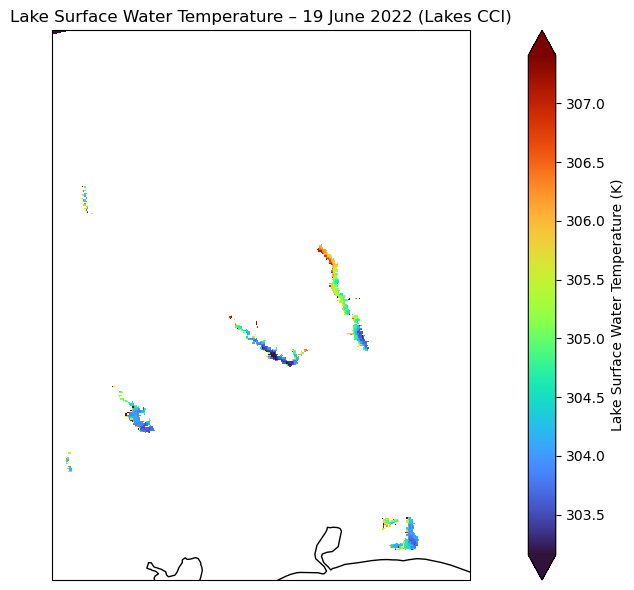

In [40]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select first (and only) time step and remove singleton dimension
lswt = lakes_ds["lake_surface_water_temperature"].isel(time=0).squeeze()
time_str = lakes_ds['time'].isel(time=0).dt.strftime('%d %B %Y').item()

# # For clarity and performance, you may want to subset the region (e.g., African lakes):
# lswt = lswt.sel(lat=slice(-15, 5), lon=slice(25, 45))

# Create figure and axis
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
mesh = lswt.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="turbo",  # or "inferno", "viridis", or "plasma"
    robust=True,
    cbar_kwargs={"label": "Lake Surface Water Temperature (K)"}
)

ax.coastlines()
ax.set_title("Lake Surface Water Temperature – " + time_str + " (Lakes CCI)")

# Add ticks
# ax.set_xticks(range(25, 45, 5), crs=ccrs.PlateCarree())  # longitude ticks
# ax.set_yticks(range(-15, 6, 5), crs=ccrs.PlateCarree())  # latitude ticks
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()